In [1]:
import outlaw.nb_util
outlaw.nb_util.setup_nb()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial
import scipy.special
import berrylib.grid as berrylibgrid
import berrylib.binomial

grid_info, sim_info, bound_info = np.load('output_berry3d.npy', allow_pickle=True)

(theta, theta_tiles, tile_radii, corners, null_truth) = grid_info
(sim_sizes, typeI_sum, typeI_score) = sim_info
(total_gp, d0_gp, d0u_gp, d1w_gp, d1uw_gp, d2uw_gp) = bound_info
n_arms = theta_tiles.shape[1]
n_arm_samples = 35
null_hypos = [
    berrylibgrid.HyperPlane(-np.identity(n_arms)[i], -scipy.special.logit(0.1)) for i in range(n_arms)
]

In [7]:
tree = scipy.spatial.KDTree(theta_tiles)
theta_pts = np.array([[-2.4,0,0]])
t0 = -2.4
n1 = 300
n2 = n1
t1 = np.linspace(-2.8, -1.2, n1)
t2 = np.linspace(-2.8, -1.2, n2)
t12 = np.stack(np.meshgrid(t1, t2, indexing='ij'), axis=-1)
eval_pts = np.concatenate([np.full((n1, n2, 1), t0), t12], axis=-1)
eval_pts = eval_pts.reshape((-1, n_arms))

In [8]:
dist, idx = tree.query(eval_pts, k=2 ** n_arms)
# if the first two distances are the same, then we to disambiguate by using the
# null_truth and the hypothesis boundaries. 
select_first = dist[:, 1] != dist[:, 0]

tile_idx = np.empty(eval_pts.shape[0], dtype=int)
tile_idx[select_first] = idx[select_first, 0]
# TODO: handle when select_first is false
# TODO: check if inside the corners of the tile?
tile_idx[:] = idx[:, 0]

In [9]:
total, d0, d0u, d1, d1u, d2u = berrylib.binomial.upper_bound(
    theta_tiles[tile_idx],
    tile_radii[tile_idx],
    eval_pts[:, None, :],
    sim_sizes[tile_idx],
    n_arm_samples,
    typeI_sum[tile_idx],
    typeI_score[tile_idx]
)

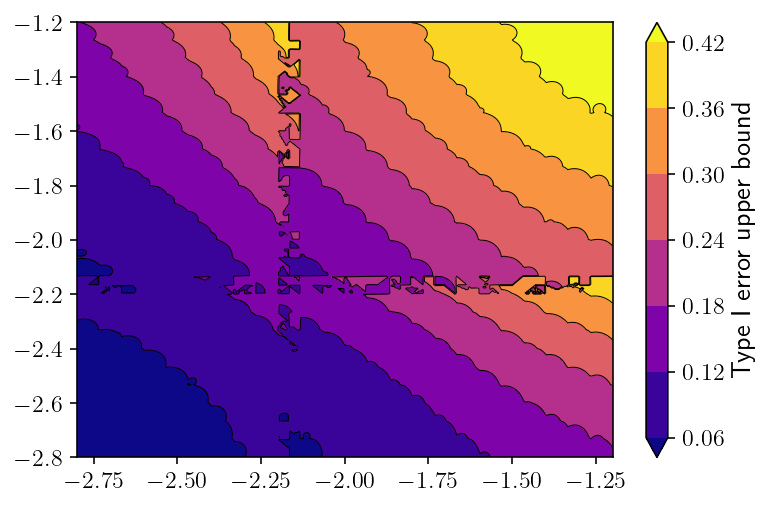

In [11]:
eval_pts_3d = eval_pts.reshape((n1, n2, 3))
x = eval_pts_3d[:, :, 1]
y = eval_pts_3d[:, :, 2]
z = (total).reshape((n1, n2))
levels = None
cntf = plt.contourf(x, y, z, levels=levels, extend="both")
plt.contour(
    x,
    y,
    z,
    levels=levels,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    extend="both",
)
cbar = plt.colorbar(cntf)
cbar.set_label('Type I error upper bound')
plt.show()

In [10]:
# d1 = np.unique(theta_tiles[selection, 0]).shape[0]
# d2 = np.unique(theta_tiles[selection, 1]).shape[0]
# x = theta_tiles[selection, 0].reshape((d1, d2))
# y = theta_tiles[selection, 1].reshape((d1, d2))
# z = total[selection].reshape((d1, d2))

ValueError: cannot reshape array of size 1089 into shape (32,32)

In [20]:
selection = np.abs(theta_tiles[:, 2] - t2) < 1e-3
plt.figure()
plt.title("Type I bound at grid points.")
plt.scatter(theta_tiles[selection, 0], theta_tiles[selection, 1], c=total[selection])
cbar = plt.colorbar()
plt.xlabel(r"$\theta_0$")
plt.ylabel(r"$\theta_1$")
cbar.set_label("Type I error")
plt.show()

ValueError: operands could not be broadcast together with shapes (12250,) (100,) 

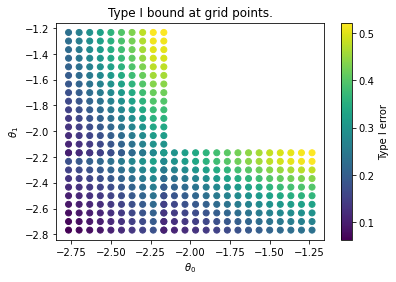

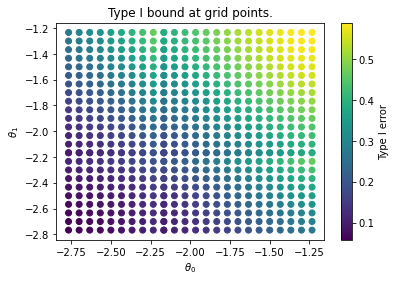

In [24]:
for t2_idx, t3_idx in [(24, 24), (16, 16), (8, 8)]:
    t2_unique = np.unique(theta_tiles[:, 2])
    if t2_idx >= t2_unique.shape[0]:
        continue
    t2 = t2_unique[t2_idx]
    selection = np.abs(theta_tiles[:, 2] - t2) < 1e-3

    plt.figure()
    plt.title("Type I bound at grid points.")
    plt.scatter(theta_tiles[selection, 0], theta_tiles[selection, 1], c=total_gp[selection])
    cbar = plt.colorbar()
    plt.xlabel(r"$\theta_0$")
    plt.ylabel(r"$\theta_1$")
    cbar.set_label("Type I error")
    plt.show()